In [37]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from glob import glob

import grl_tools

In [2]:
# Load Serap's icetop GRL files
grl_base = '/data/ana/CosmicRay/IceTop_GRL'
grl_files = sorted(glob(f'{grl_base}/IC86_20*.txt'))

it_goodruns = []
for grl_file in grl_files:
    it_goodruns += grl_tools.parse_seraps_GRL(grl_file)

In [3]:
# Load information from i3live
start = '2012-05-13 00:00:00'
end   = '2022-05-13 00:00:00'
i3_goodruns = grl_tools.i3live_grl(start, end, icetop=True)

In [4]:
# Calculate livetimes for icetop
i3_livetime = grl_tools.daily_livetime(i3_goodruns, it_goodruns)

10.2% of runs filtered out by IT GRL


In [39]:
# We need the counts for each day in the IceTop maps. Create a count finder?

In [40]:
prefix = '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa'
print(sorted(glob(f'{prefix}/*')))

['/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/nocuts_anti', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/nocuts_solar', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/sp_nocuts_anti', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/sp_nocuts_solar', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier1_anti', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier1_unblinded', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier2_anti', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier2_unblinded', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier3_anti', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier3_unblinded', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier4_anti', '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier4_unblinded']


In [44]:
prefix = '/data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier1_unblinded/ITpass2'
test = sorted(glob(f'{prefix}/2011-*'))
for day in test:
    ymd = day.split('/')[-1]
    print(ymd)

2011-05-13
2011-05-14
2011-05-15
2011-05-16
2011-05-17
2011-05-18
2011-05-19
2011-05-20
2011-05-21
2011-05-22
2011-05-23
2011-05-24
2011-05-25
2011-05-26
2011-05-27
2011-05-28
2011-05-29
2011-05-30
2011-05-31
2011-06-01
2011-06-02
2011-06-03
2011-06-04
2011-06-05
2011-06-06
2011-06-07
2011-06-08
2011-06-09
2011-06-10
2011-06-11
2011-06-12
2011-06-13
2011-06-14
2011-06-15
2011-06-16
2011-06-17
2011-06-18
2011-06-19
2011-06-20
2011-06-21
2011-06-22
2011-06-23
2011-06-24
2011-06-25
2011-06-26
2011-06-27
2011-06-28
2011-06-29
2011-06-30
2011-07-01
2011-07-02
2011-07-03
2011-07-04
2011-07-05
2011-07-06
2011-07-07
2011-07-08
2011-07-09
2011-07-10
2011-07-11
2011-07-12
2011-07-13
2011-07-14
2011-07-15
2011-07-16
2011-07-17
2011-07-18
2011-07-19
2011-07-20
2011-07-21
2011-07-22
2011-07-23
2011-07-24
2011-07-25
2011-07-26
2011-07-27
2011-07-28
2011-07-29
2011-07-30
2011-07-31
2011-08-01
2011-08-02
2011-08-03
2011-08-04
2011-08-05
2011-08-06
2011-08-07
2011-08-08
2011-08-09
2011-08-10
2011-08-11

In [45]:
from astropy.io import fits

In [48]:
# Open the FITS file
hdul = fits.open(map_file)

# See what's inside
hdul.info()

# Access the primary HDU data and header
data = hdul[1].data
header = hdul[1].header

# Optional: close the file
hdul.close()

Filename: /data/ana/CosmicRay/Anisotropy/IceTop/ITpass2/output/outputa/tier1_unblinded/ITpass2/2012-09-10/CR_ICETOP_LOCAL_3-5S_NSIDE64_degbin-359.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  xtension      1 BinTableHDU     18   48R x 1C   [1024D]   


In [55]:
print(np.sum([row[0] for row in data]))

1327.0


In [35]:
data_tot = np.zeros(hp.nside2npix(64))

for map_file in map_files:
    data = hp.read_map(map_file)
    data_tot += data

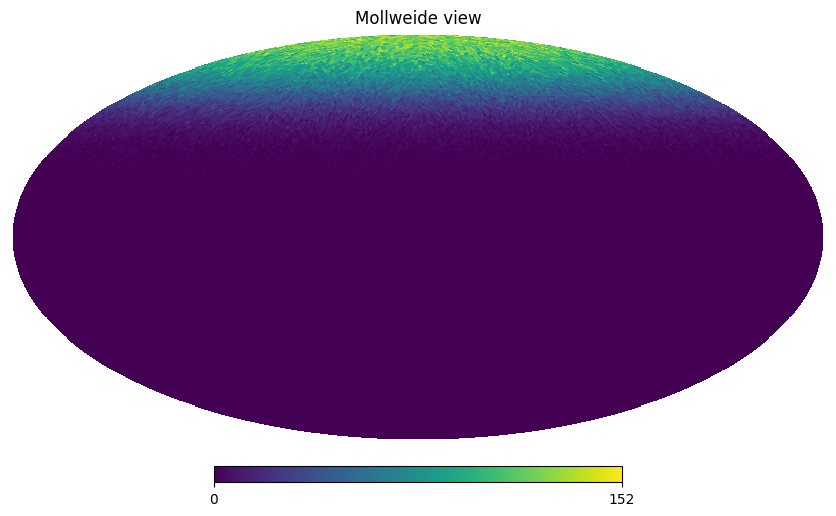

In [36]:
hp.mollview(data_tot)